# Explication du notebook

Modèle avec Attention pour l'Interprétabilité

## Objectif du Notebook :
Ce notebook améliore le modèle en ajoutant un mécanisme d'attention pour aider à comprendre quelles parties des données sont les plus importantes pour la prédiction. Le modèle utilise un mécanisme d'attention, permettant de mettre en évidence quelles "tuiles" d'images ou parties des données sont les plus influentes.

## Étapes :

Définition d'un modèle avec une couche d'attention qui aide à apprendre quelles parties des caractéristiques sont les plus importantes.

Utilisation de ce modèle pour effectuer des prédictions sur les échantillons et afficher les tuiles ayant l'attention la plus élevée.

Sauvegarde des résultats dans un fichier CSV pour pouvoir les examiner plus tard.

### Ce qui est affiché :

Une figure contenant les images des tuiles les plus importantes pour chaque échantillon, basées sur les poids d'attention.

Un fichier CSV avec les prédictions du modèle.

## Explication Plus Poussée :
Mécanisme d'Attention :
Le modèle de base est amélioré avec un mécanisme d'attention qui permet au modèle de "se concentrer" sur certaines parties des caractéristiques (les tuiles). Cela se fait via une couche d'attention qui attribue un poids à chaque tuile en fonction de son importance pour la tâche de classification. Les tuiles ayant un poids élevé sont celles qui contribuent le plus à la prédiction du modèle.

### Affichage des Tuiles les Plus Attentivement Pondérées :
Une fois que le modèle a effectué une prédiction, la fonction show_top_tiles est utilisée pour afficher les top_k tuiles ayant les poids d'attention les plus élevés. Cela permet aux chercheurs de mieux comprendre le comportement du modèle en visualisant quelles parties de l'image sont les plus influentes pour la prédiction.

### Sauvegarde des Résultats :
Le modèle est testé sur un jeu de test et les résultats sont sauvegardés dans un fichier CSV. Ce fichier peut être utilisé pour l'analyse ultérieure, ce qui est essentiel pour un processus reproductible dans un environnement de production.

## Questions à Se Poser :
Pourquoi avons-nous utilisé un mécanisme d'attention ici ?

Comment le mécanisme d'attention peut-il aider à l'interprétabilité du modèle ?

Quelles informations peut-on tirer des tuiles avec les poids d'attention les plus élevés ?

Quelle est la signification des résultats dans le fichier CSV ? Comment peuvent-ils être utilisés pour des prédictions futures ?

Comment le modèle avec attention se compare-t-il au modèle de régression logistique simple ? Est-il plus efficace ?

Le modèle est-il plus robuste et interprétable grâce à l'attention ?



# Basics

First, we need to know if we're working with attention pooling or mean pooling.

In [1]:
mean_pool = False
attention_pool = True

## Dependencies

In [2]:
!pip install torch
!pip install torchvision
!pip install scikit-learn



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Data preparation

### Imports and BRCA

In [3]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

class BRCAFeatureDataset(Dataset):
    """
    Dataset PyTorch personnalisé pour charger les features et labels
    des échantillons du dataset BRCA.

    Chaque échantillon est un ensemble de vecteurs de features (2048-dim) 
    extraits à partir d'images histopathologiques, stockés sous forme de .npy.
    """

    def __init__(self, feature_dir, label_df):
        """
        Args:
            feature_dir (str or Path): Dossier contenant les fichiers .npy de features.
            label_df (pd.DataFrame): DataFrame avec 'Sample ID' en index et une colonne 'Target'.
        """
        self.feature_dir = feature_dir
        self.sample_ids = label_df.index.tolist()   # Liste des IDs d'échantillons
        self.labels = label_df["Target"].values     # Labels associés (0 ou 1)

    def __len__(self):
        """Retourne le nombre total d’échantillons dans le dataset."""
        return len(self.sample_ids)

    def __getitem__(self, idx):
        """
        Charge les features et le label d’un échantillon donné.
        
        Args:
            idx (int): Index de l’échantillon à charger.

        Returns:
            features (torch.Tensor): Matrice des features de forme (1000, 2048).
            label (torch.Tensor): Label binaire (0 ou 1) du sample.
        """
        sample_id = self.sample_ids[idx]
        label = self.labels[idx]

        # Chargement du fichier de features .npy
        feature_path = os.path.join(self.feature_dir, f"{sample_id}")
        mat = np.load(feature_path)

        # On ne garde que les colonnes de features (on supprime les 3 premières colonnes)
        features = mat[:, 3:] # shape: (1000, 2048)

        # Retour sous forme de tenseurs PyTorch
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


### Paths

In [4]:
# Paths
data_dir_dam = Path("C:/Users/Archi/Documents/Ponts/Cours/S2/Datbi/DATBI2025-CANCER/DataSets") # replace with your own path
features_dir = data_dir_dam / "train_input" / "moco_features"
images_dir = data_dir_dam / "train_input" / "images"
labels_path = data_dir_dam / "train_output.csv"

# Load labels
labels_df = pd.read_csv(labels_path)
labels_df.set_index("Sample ID", inplace=True)

# Split train/test
from sklearn.model_selection import train_test_split


# seperate training and validation datasets with the train_test_split right before
train_ids, val_ids = train_test_split(labels_df, test_size=0.2, stratify=labels_df["Target"], random_state=42)
train_dataset = BRCAFeatureDataset(features_dir, train_ids)
val_dataset   = BRCAFeatureDataset(features_dir, val_ids)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)


# Pytorch Model

## Defining the model - mean pooling

Why ?

Treats all tiles equally.

Every tile contributes the same weight to the final prediction.

Very fast and simple, but can ignore important regional patterns.

🟡 Pros: Easy to implement, runs fast
🔴 Cons: Can't focus on more relevant tiles, less interpretable

The following code talks about an MLP. In french :
- un MLP (pour Multilayer Perceptron) est un type de réseau de neurones artificiels à couches entièrement connectées. Il est composé d'une ou plusieurs couches cachées entre une couche d'entrée et une couche de sortie, et il est souvent utilisé pour des tâches de classification ou de régression.

🔧 Structure typique d’un MLP :
- Entrée : un vecteur de features (par ex. 2048 valeurs dans ton cas).
- Couches cachées : chaque neurone de la couche est connecté à tous les neurones de la couche précédente. Ces couches incluent souvent :
- Une transformation linéaire (nn.Linear)
- Une fonction d’activation non-linéaire (ReLU, Tanh, etc.)
- Éventuellement de la régularisation (Dropout)
- Sortie : un ou plusieurs neurones, selon la tâche (1 neurone avec une sigmoïde pour la classification binaire).

In [5]:
import torch.nn as nn

class BRCAClassifier(nn.Module):
    """
    Réseau de neurones pour la classification binaire à partir de features extraits d'images histologiques.

    Chaque échantillon est représenté par un ensemble de "tiles" (sous-images), chacune ayant 2048 features.
    Le modèle applique un MLP aux tiles individuellement, puis effectue un pooling moyen
    pour agréger l'information et prédire la probabilité d'appartenance à la classe positive.
    """

    def __init__(self, in_features=2048, hidden_size=512):
        """
        Args:
            in_features (int): Taille des vecteurs de features en entrée (2048 par défaut).
            hidden_size (int): Taille de la couche cachée intermédiaire.
        """
        super().__init__()

        # Réseau appliqué à chaque tile individuellement (MLP)
        self.tile_fc = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        # Classifieur final après pooling (sigmoïde pour sortie entre 0 et 1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Args:
            x (Tensor): Tensor de forme (batch_size, num_tiles, 2048)

        Returns:
            Tensor: Probabilités prédictives de forme (batch_size,)
        """
        B, T, F = x.size()

        # Passage des tiles à travers le réseau de feature extraction
        x = self.tile_fc(x)  # (B, T, hidden_size)

        # Moyennage des features sur les tiles (pooling moyen)
        x = x.mean(dim=1)    # (B, hidden_size)

        # Passage à travers le classifieur final
        x = self.classifier(x)  # (B, 1)

        return x.squeeze(1)  # Retire la dimension inutile → (B,)


## Attention Pool layer

### Class

In [6]:
class AttentionPool(nn.Module):
    """
    Module de pooling par attention pour agréger un ensemble de vecteurs de features (tiles).

    Chaque tile est pondéré par une attention calculée à l’aide d’un petit réseau neuronal.
    Le vecteur final est une somme pondérée des tiles, où les poids sont appris automatiquement.
    """

    def __init__(self, input_dim, hidden_dim=128):
        """
        Args:
            input_dim (int): Dimension des vecteurs de features en entrée.
            hidden_dim (int): Taille de la couche cachée dans le mécanisme d’attention.
        """
        super().__init__()

        # Réseau d'attention : calcule un score de pertinence pour chaque tile
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # projection
            nn.Tanh(),                         # non-linéarité
            nn.Linear(hidden_dim, 1)           # score scalaire pour chaque tile
        )

    def forward(self, x):
        """
        Args:
            x (Tensor): Tensor de forme (B, T, F), où
                        B = batch size,
                        T = nombre de tiles par échantillon,
                        F = dimension des features.

        Returns:
            x_att (Tensor): Représentation agrégée de forme (B, F), somme pondérée des tiles.
            A (Tensor): Poids d’attention (B, T, 1), indiquant l’importance de chaque tile.
        """
        A = self.attention(x)              # Calcule les scores d’attention → (B, T, 1)
        A = torch.softmax(A, dim=1)        # Normalise les scores pour obtenir des poids → (B, T, 1)
        x_att = torch.sum(x * A, dim=1)    # Produit pondéré des tiles → (B, F)
        return x_att, A                    # Retourne la représentation et les poids d’attention


Why ? 

Learns to assign a different weight to each tile.

Important tiles (e.g. tumor regions) get higher attention scores.

Helps model focus on the right parts of the tissue.

The attention weights are interpretable (you can visualize them!).

🟢 Pros: Better performance, interpretable, focuses on relevant tiles
🔵 Cons: Slightly more complex, a bit slower to train

### Main model updated with attention pool

In [7]:
class BRCAClassifierWithAttention(nn.Module):
    """
    Réseau de neurones pour la classification binaire BRCA utilisant un mécanisme
    de pooling par attention pour agréger les features des tiles.

    Chaque tile est encodé via un MLP, puis une attention apprend à pondérer
    leur importance relative pour produire une représentation globale.
    """

    def __init__(self, in_features=2048, hidden_size=512):
        """
        Args:
            in_features (int): Dimension des features d'entrée par tile.
            hidden_size (int): Taille des couches cachées.
        """
        super().__init__()

        # MLP appliqué individuellement à chaque tile
        self.tile_fc = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        # Module d'aggregation par attention
        self.attention_pool = AttentionPool(hidden_size)

        # Classifieur final à partir du vecteur agrégé
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()  # Pour prédire une probabilité binaire
        )

    def forward(self, x, return_attention=False):
        """
        Args:
            x (Tensor): Entrée de forme (B, T, F), features des tiles.
            return_attention (bool): Si True, retourne aussi les poids d’attention.

        Returns:
            Tensor: Prédictions de forme (B,)
            Tensor (optionnel): Poids d’attention de forme (B, T) si `return_attention` est True.
        """
        x = self.tile_fc(x)                  # Encodage de chaque tile → (B, T, hidden)
        x_att, A = self.attention_pool(x)    # Pooling attentionné → (B, hidden), (B, T, 1)
        out = self.classifier(x_att).squeeze(1)  # Prédiction → (B,)

        if return_attention:
            return out, A.squeeze(2)  # Retourne aussi les poids d’attention → (B, T)

        return out


## Training the model

In [8]:
# Détecte si un GPU est disponible et sélectionne le périphérique approprié
# Si CUDA est disponible (GPU), on utilise "cuda", sinon on tombe sur "cpu".
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choisir le modèle en fonction de la méthode de pooling spécifiée
# Selon la variable `mean_pool` ou `attention_pool`, on instancie l'un des modèles.

if mean_pool:
    # Si la méthode de pooling est "mean_pool", on utilise le modèle de base BRCAClassifier
    model = BRCAClassifier().to(device)  # Déplacement du modèle sur le périphérique (GPU ou CPU)
elif attention_pool:
    # Si la méthode de pooling est "attention_pool", on utilise le modèle avec attention
    model = BRCAClassifierWithAttention().to(device)  # Déplacement du modèle sur le périphérique (GPU ou CPU)
else:
    # Si aucune méthode de pooling valide n'est sélectionnée, on soulève une erreur
    raise ValueError("Please select a pooling method: mean_pool or attention_pool, in first cell of notebook.")


In [9]:
import torch.optim as optim

# Définition de la fonction de perte et de l'optimiseur
# Utilisation de la Binary Cross Entropy Loss (BCELoss) pour un problème de classification binaire
criterion = nn.BCELoss()

# Optimiseur Adam pour ajuster les poids du modèle avec un taux d'apprentissage de 1e-4
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def evaluate(loader):
    """
    Fonction d'évaluation du modèle pour calculer les prédictions et obtenir les scores AUC.

    Args:
        loader (DataLoader): Le DataLoader contenant les données de validation ou de test.

    Returns:
        y_true (list): Liste des labels réels.
        y_pred (list): Liste des prédictions du modèle.
    """
    model.eval()  # Mettez le modèle en mode évaluation (désactive le dropout, batchnorm, etc.)
    y_true, y_pred = [], []

    # Pas de gradient nécessaire lors de l'évaluation
    with torch.no_grad():
        for x_batch, y_batch in loader:
            # Déplace les données vers le périphérique (GPU ou CPU)
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Passage à travers le modèle pour obtenir les sorties
            outputs = model(x_batch)

            # Convertit les sorties et les labels en numpy et les ajoute à nos listes
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    return y_true, y_pred


from sklearn.metrics import roc_auc_score

# Boucle d'entraînement pour 10 époques
for epoch in range(10):
    model.train()  # Mise du modèle en mode entraînement (active le dropout, batchnorm, etc.)

    # Boucle sur les données d'entraînement
    for x_batch, y_batch in train_loader:
        # Déplace les batchs sur le périphérique (GPU ou CPU)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Réinitialisation des gradients de l'optimiseur
        optimizer.zero_grad()

        # Passage des données dans le modèle pour obtenir les prédictions
        outputs = model(x_batch)

        # Calcul de la perte entre les prédictions et les labels réels
        loss = criterion(outputs, y_batch)

        # Rétropropagation pour calculer les gradients
        loss.backward()

        # Mise à jour des poids du modèle
        optimizer.step()

    # Évaluation à la fin de chaque époque sur le DataLoader de validation
    y_true, y_pred = evaluate(val_loader)

    # Calcul du score AUC-ROC pour évaluer la qualité de la prédiction
    auc = roc_auc_score(y_true, y_pred)

    # Affichage du score AUC-ROC pour la validation après chaque époque
    print(f"Epoch {epoch+1}: Validation AUC = {auc:.4f}")


Epoch 1: Validation AUC = 0.5447
Epoch 2: Validation AUC = 0.5385
Epoch 3: Validation AUC = 0.5698
Epoch 4: Validation AUC = 0.5868
Epoch 5: Validation AUC = 0.5912
Epoch 6: Validation AUC = 0.6055
Epoch 7: Validation AUC = 0.6342
Epoch 8: Validation AUC = 0.6297
Epoch 9: Validation AUC = 0.6360
Epoch 10: Validation AUC = 0.6413


# Predict Mutation Probabilities for All Samples

## Predictions and output.csv

In [22]:
import datetime

def predict_and_save(model, dataset, label_df, output_dir="DataSets/Outputs/", prefix="train_output"):
    """
    Effectue des prédictions sur un jeu de données et sauvegarde les résultats dans un fichier CSV.

    Cette fonction exécute les prédictions pour chaque échantillon dans le dataset donné, 
    puis sauvegarde ces prédictions sous la forme d'un fichier CSV avec un timestamp unique.

    Args:
        model (nn.Module): Le modèle de classification.
        dataset (Dataset): Le jeu de données contenant les features à prédire.
        label_df (DataFrame): Le DataFrame contenant les identifiants des échantillons.
        output_dir (str): Le répertoire où les résultats seront sauvegardés. Par défaut, "DataSets/Outputs/".
        prefix (str): Le préfixe utilisé pour nommer le fichier de sortie. Par défaut, "train_output".
        
    Returns:
        None
    """
    model.eval()  # Met le modèle en mode évaluation (désactive les mécanismes comme le dropout)
    results = []  # Liste pour stocker les résultats (ID de l'échantillon et la probabilité de la classe positive)

    with torch.no_grad():  # Désactive la mise à jour des gradients pendant la prédiction
        for i in range(len(dataset)):
            # Récupère les features et les labels associés à chaque échantillon
            features, _ = dataset[i]
            sample_id = label_df.index[i]  # Récupère l'ID de l'échantillon à partir du DataFrame des labels

            features = features.unsqueeze(0).to(device)  # Ajoute une dimension pour simuler un batch (shape: 1, 1000, 2048)
            prob = model(features).item()  # Passe les features dans le modèle pour obtenir la probabilité (entre 0 et 1)

            # Ajoute le résultat sous forme de tuple (ID échantillon, probabilité)
            results.append((sample_id, prob))

    # Trie les résultats par ID d'échantillon
    results = sorted(results, key=lambda x: x[0])

    # Crée un nom de fichier unique basé sur l'horodatage actuel
    timestamp = datetime.datetime.now().strftime("%m_%d-%H_%M")
    out_path = os.path.join(output_dir, f"{prefix}-{timestamp}.csv")

    # Crée un DataFrame à partir des résultats et sauvegarde en fichier CSV
    df_out = pd.DataFrame(results, columns=["Sample ID", "Target"])
    df_out.to_csv(out_path, index=False)  # Sauvegarde sans inclure l'index
    print(f"Saved predictions to: {out_path}")


In [23]:
predict_and_save(model, train_dataset, train_ids)


Saved predictions to: DataSets/Outputs/train_output-05_09-14_07.csv


## ROC curve and AUC

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


In [25]:
def plot_roc_curve(model, val_loader):
    """
    Génère et affiche la courbe ROC pour évaluer les performances du modèle.

    Cette fonction évalue les prédictions du modèle sur un DataLoader de validation,
    calcule la courbe ROC et le score AUC, puis les trace à l'aide de Matplotlib.

    Args:
        model (nn.Module): Le modèle de classification à évaluer.
        val_loader (DataLoader): Le DataLoader contenant les données de validation.

    Returns:
        None
    """
    model.eval()  # Met le modèle en mode évaluation (désactive le dropout et autres comportements d'entraînement)
    y_true = []   # Liste pour stocker les labels réels
    y_scores = [] # Liste pour stocker les scores de prédiction (probabilités)

    # Pas de calcul de gradients nécessaire pendant l'évaluation
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)   # Déplace les données sur le périphérique (GPU ou CPU)
            y_batch = y_batch.to(device)   # Déplace les labels sur le périphérique

            # Obtenir les probabilités de prédiction du modèle
            y_pred = model(x_batch)  # La sortie du modèle est une probabilité entre 0 et 1

            # Ajouter les valeurs aux listes
            y_true.extend(y_batch.cpu().numpy())  # Labels réels
            y_scores.extend(y_pred.cpu().numpy())  # Scores de prédiction

    # Calcul des taux de faux positifs (fpr) et vrais positifs (tpr) pour la courbe ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    
    # Calcul du score AUC (Area Under Curve)
    auc = roc_auc_score(y_true, y_scores)

    # Tracer la courbe ROC
    plt.figure(figsize=(7, 6))  # Taille de la figure
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)  # Courbe ROC
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonale (AUC = 0.5)
    plt.xlabel("False Positive Rate")  # Légende de l'axe X
    plt.ylabel("True Positive Rate")   # Légende de l'axe Y
    plt.title("ROC Curve")  # Titre de la courbe
    plt.legend(loc="lower right")  # Légende dans le coin inférieur droit
    plt.grid(True)  # Ajoute une grille pour la lisibilité
    plt.tight_layout()  # Ajuste automatiquement l'espacement de la figure
    plt.show()  # Affiche la courbe


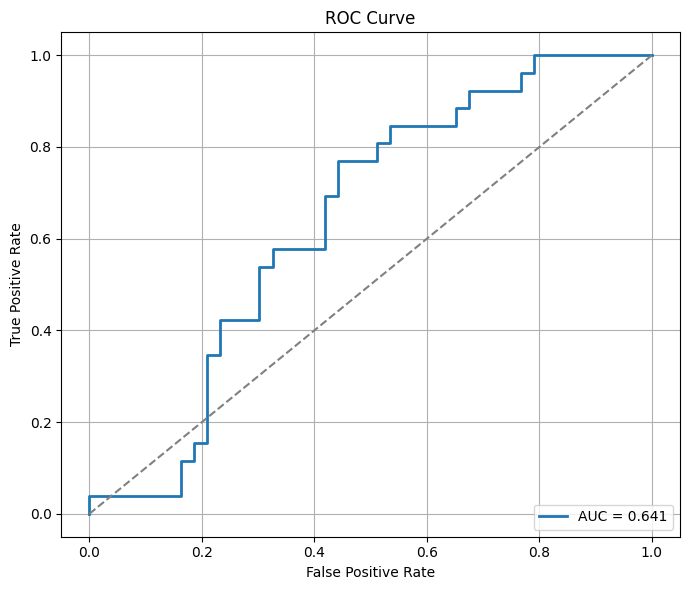

In [26]:
# Call the function
plot_roc_curve(model, val_loader)


### Visualize Most Attended Tiles

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import glob

def show_top_tiles(sample_id, model, top_k=9):
    """
    Affiche les `top_k` tuiles ayant reçu le plus d'attention par le modèle pour un échantillon donné.

    Cette fonction charge les features de l'échantillon, calcule les poids d'attention à l'aide du modèle,
    puis affiche les `top_k` tuiles ayant les plus grands poids d'attention.

    Args:
        sample_id (str): L'ID de l'échantillon à analyser.
        model (nn.Module): Le modèle de classification avec attention.
        top_k (int, optionnel): Le nombre de tuiles à afficher, par défaut 9.

    Returns:
        None
    """
    model.eval()  # Met le modèle en mode évaluation

    # Charger les features pour cet échantillon
    npy_path = features_dir / f"{sample_id}.npy"  # Chemin vers les features .npy
    img_folder = images_dir / f"{sample_id}"      # Dossier contenant les images des tuiles

    features = np.load(npy_path)  # Charge les features (1000, 2051)
    coords = features[:, 1:3]     # Coordonnées x et y des tuiles (non utilisé ici)
    tiles = features[:, 3:]       # Features MoCo des tuiles (1000 x 2048)

    # Calculer les poids d'attention
    with torch.no_grad():  # Pas de calcul de gradients pendant l'inférence
        input_tensor = torch.tensor(tiles, dtype=torch.float32).unsqueeze(0).to(device)  # Forme le batch
        _, attention_weights = model(input_tensor, return_attention=True)  # Obtenir les poids d'attention
        attention_weights = attention_weights[0].cpu().numpy()  # Récupérer les poids d'attention sur le CPU

    # Trier les indices des tuiles par ordre décroissant de poids d'attention
    top_indices = np.argsort(-attention_weights)[:top_k]  # Indices des tuiles ayant le plus grand poids d'attention

    # Obtenir les chemins des images de toutes les tuiles
    tile_files = sorted(glob.glob(f"{img_folder}/*.jpg"))  # Récupère tous les fichiers d'images des tuiles
    tile_map = {}
    for path in tile_files:
        fname = os.path.basename(path)
        tile_id = int(fname.split('_tile_')[1].split('_')[0])  # Extraction de l'ID de la tuile
        tile_map[tile_id] = path  # Mapping entre ID de tuile et chemin d'image

    # Afficher les images des tuiles avec les plus grands poids d'attention
    fig, axes = plt.subplots(1, top_k, figsize=(15, 4))  # Création d'une grille de sous-graphes
    for i, idx in enumerate(top_indices):
        tile_path = tile_map.get(idx)  # Trouver le chemin de la tuile correspondant à l'indice
        if tile_path and os.path.exists(tile_path):  # Si le fichier d'image existe
            img = Image.open(tile_path)  # Ouvrir l'image
            axes[i].imshow(img)  # Afficher l'image dans le subplot
            axes[i].set_title(f"w={attention_weights[idx]:.2f}")  # Afficher le poids d'attention
        else:
            axes[i].set_title("Missing")  # Si l'image est manquante, afficher "Missing"
        axes[i].axis('off')  # Supprimer les axes pour ne garder que les images

    # Afficher un titre global pour la figure
    plt.suptitle(f"Top {top_k} Attended Tiles - Sample {sample_id}")
    plt.tight_layout()  # Ajuster les espacements pour que tout soit bien visible
    plt.show()  # Afficher la figure


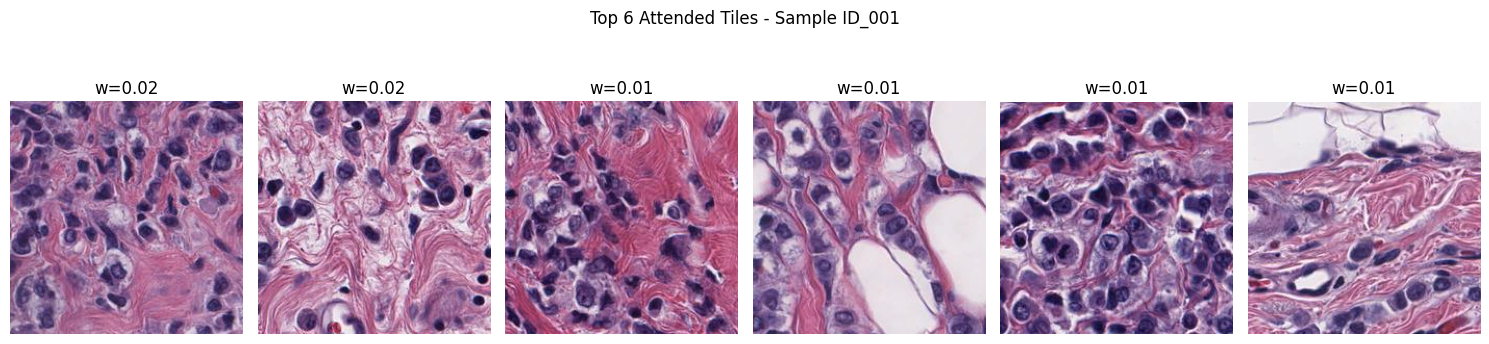

In [16]:
sample_to_visualize = "ID_001"  # replace with real sample ID
show_top_tiles(sample_to_visualize, model, top_k=6)


# No labels dataclass

### Test Set Dataset Class (No labels)

In [17]:
class BRCATestFeatureDataset(Dataset):
    """
    Dataset pour charger les features de test à partir des fichiers .npy.

    Cette classe permet de charger les features (moco) à partir des fichiers `.npy` pour chaque échantillon
    en vérifiant leur existence avant de les inclure dans le dataset. Les échantillons sans fichiers associés
    sont filtrés.

    Args:
        feature_dir (str): Répertoire contenant les fichiers .npy des features.
        metadata_df (pd.DataFrame): DataFrame contenant les métadonnées des échantillons (au moins "Sample ID").

    Attributes:
        feature_dir (str): Répertoire où sont stockées les features.
        sample_ids (list): Liste des IDs des échantillons présents dans le dataset, après filtrage.
    """
    
    def __init__(self, feature_dir, metadata_df):
        """
        Initialise le dataset en filtrant les échantillons manquants.
        
        Args:
            feature_dir (str): Répertoire contenant les fichiers .npy des features.
            metadata_df (pd.DataFrame): DataFrame contenant les métadonnées des échantillons.
        """
        self.feature_dir = feature_dir
        self.sample_ids = metadata_df["Sample ID"].tolist()  # Extraire les ID des échantillons

        # Filtrer les échantillons pour lesquels les fichiers .npy existent
        self.sample_ids = [sample_id for sample_id in self.sample_ids
                           if os.path.exists(os.path.join(feature_dir, f"{sample_id}"))]

    def __len__(self):
        """
        Renvoie la taille du dataset (nombre d'échantillons valides).

        Returns:
            int: Nombre d'échantillons valides dans le dataset.
        """
        return len(self.sample_ids)

    def __getitem__(self, idx):
        """
        Renvoie les features pour un échantillon donné à partir de son index.
        
        Args:
            idx (int): L'index de l'échantillon à récupérer.
        
        Returns:
            tuple: Un tuple contenant l'ID de l'échantillon et les features (tensor).
        """
        sample_id = self.sample_ids[idx]
        feature_path = os.path.join(self.feature_dir, f"{sample_id}")

        # Si le fichier est manquant (même après filtrage), lever une exception
        if not os.path.exists(feature_path):
            raise FileNotFoundError(f"File {feature_path} not found.")

        # Charger les features à partir du fichier .npy
        mat = np.load(feature_path)
        features = mat[:, 3:]  # Extraire les features MoCo (les colonnes après les 3 premières)
        
        # Retourner l'ID de l'échantillon et les features sous forme de tensor
        return sample_id, torch.tensor(features, dtype=torch.float32)


### Predict on Test Set + Save to CSV

In [ ]:
def predict_test_set(model, test_dataset, output_dir="DataSets/Outputs/", prefix="test_output"):
    """
    Effectue des prédictions sur l'ensemble de test et sauvegarde les résultats dans un fichier CSV.

    Cette fonction évalue le modèle sur un dataset de test, effectue des prédictions sur les features
    de chaque échantillon et sauvegarde les résultats dans un fichier CSV.

    Args:
        model (torch.nn.Module): Le modèle pré-entraîné utilisé pour effectuer les prédictions.
        test_dataset (Dataset): Un objet Dataset contenant les features des échantillons à prédire.
        output_dir (str, optionnel): Répertoire où les résultats seront sauvegardés. Par défaut, "DataSets/Outputs/".
        prefix (str, optionnel): Préfixe utilisé pour nommer le fichier de sortie. Par défaut, "test_output".

    Returns:
        None: Les résultats sont directement sauvegardés dans un fichier CSV.
    """
    model.eval()  # Met le modèle en mode évaluation (désactive le dropout, batchnorm, etc.)
    results = []  # Liste pour stocker les résultats des prédictions (ID de l'échantillon, probabilité)

    with torch.no_grad():  # Désactive le calcul des gradients (pas de backpropagation)
        for sample_id, features in test_dataset:
            npy_path = os.path.join(test_dataset.feature_dir, f"{sample_id}")

            # Vérifier si le fichier .npy existe avant de traiter cet échantillon
            if not os.path.exists(npy_path):
                print(f"Warning: {npy_path} not found, skipping this sample.")
                continue  # Passer l'échantillon si le fichier .npy est manquant

            features = features.unsqueeze(0).to(device)  # Ajouter une dimension batch (1, 1000, 2048)
            prob = model(features).item()  # Prédiction: sortie du modèle (probabilité entre 0 et 1)
            results.append((sample_id, prob))  # Ajouter l'ID de l'échantillon et la probabilité aux résultats

    # Trier les résultats par ID d'échantillon
    results = sorted(results, key=lambda x: x[0])

    # Générer un nom de fichier avec un timestamp pour l'unicité
    timestamp = datetime.datetime.now().strftime("%m_%d-%H_%M")
    out_path = os.path.join(output_dir, f"{prefix}-{timestamp}.csv")

    # Sauvegarder les résultats dans un fichier CSV
    df_out = pd.DataFrame(results, columns=["Sample ID", "Target"])  # Création du DataFrame
    df_out.to_csv(out_path, index=False)  # Sauvegarder le DataFrame dans un fichier CSV
    print(f"Test predictions saved to: {out_path}")


In [19]:
meta_data_path = data_dir_dam / "supplementary_data"
test_file = meta_data_path / "test_metadata.csv"

test_meta = pd.read_csv(test_file)
test_dataset = BRCATestFeatureDataset(features_dir, test_meta)

predict_test_set(model, test_dataset)


Test predictions saved to: DataSets/Outputs/test_output-05_09-14_00.csv


### Tile-Level Attention Visualization

In [ ]:
def show_top_tiles(sample_id, model, top_k=9, feature_dir=features_dir, img_dir=images_dir):
    """
    Affiche les top-k tuiles les plus attentivement pondérées par le modèle pour un échantillon donné.

    Cette fonction charge les caractéristiques (features) et les images des tuiles associées à un échantillon,
    effectue une prédiction du modèle avec attention, et affiche les `top_k` tuiles ayant les plus grandes
    pondérations d'attention.

    Args:
        sample_id (str): L'ID de l'échantillon pour lequel les tuiles doivent être affichées.
        model (torch.nn.Module): Le modèle de classification utilisé pour calculer les poids d'attention.
        top_k (int, optionnel): Le nombre de tuiles à afficher, triées par leur poids d'attention. Par défaut, 9.
        feature_dir (str, optionnel): Le répertoire contenant les fichiers .npy avec les caractéristiques des tuiles.
        img_dir (str, optionnel): Le répertoire contenant les images des tuiles.

    Returns:
        None: Affiche une figure matplotlib avec les `top_k` tuiles.
    """
    model.eval()  # Met le modèle en mode évaluation (désactive le dropout et batchnorm)

    # Charger les caractéristiques de l'échantillon
    npy_path = os.path.join(feature_dir, f"{sample_id}.npy")
    folder = os.path.join(img_dir, sample_id)
    features = np.load(npy_path)  # Charger le fichier .npy contenant les caractéristiques des tuiles
    coords = features[:, 1:3]  # Extraire les coordonnées des tuiles (non utilisées ici)
    tiles = features[:, 3:]  # Extraire les caractéristiques des tuiles (2048 dimensions par tuile)

    # Désactiver le calcul des gradients et passer les tuiles dans le modèle pour obtenir les poids d'attention
    with torch.no_grad():
        x = torch.tensor(tiles, dtype=torch.float32).unsqueeze(0).to(device)  # Ajouter une dimension batch
        _, attention = model(x, return_attention=True)  # Retourner à la fois la prédiction et les poids d'attention
        attention = attention[0].cpu().numpy()  # Extraire les poids d'attention pour chaque tuile

    # Trier les indices des tuiles par les poids d'attention (ordre décroissant)
    top_indices = np.argsort(-attention)[:top_k]  # Top-k indices des tuiles avec les poids d'attention les plus élevés

    # Charger les images des tuiles
    tile_files = sorted(glob.glob(os.path.join(folder, "*.jpg")))  # Obtenir les chemins des images des tuiles
    tile_map = {}  # Dictionnaire pour mapper les indices des tuiles aux chemins des images
    for path in tile_files:
        fname = os.path.basename(path)
        tile_id = int(fname.split('_tile_')[1].split('_')[0])  # Extraire l'ID de la tuile depuis le nom du fichier
        tile_map[tile_id] = path

    # Créer une figure avec un sous-graphe pour chaque tuile
    fig, axes = plt.subplots(1, top_k, figsize=(16, 4))  # Créer une figure avec `top_k` sous-graphiques
    for i, idx in enumerate(top_indices):
        tile_path = tile_map.get(idx)  # Trouver le chemin de l'image correspondant à l'indice de la tuile
        if tile_path and os.path.exists(tile_path):
            img = Image.open(tile_path)  # Charger l'image de la tuile
            axes[i].imshow(img)  # Afficher l'image dans le sous-graphe
            axes[i].set_title(f"w={attention[idx]:.2f}")  # Afficher le poids d'attention comme titre de la tuile
        else:
            axes[i].set_title("Missing")  # Si l'image est manquante, afficher "Missing"
        axes[i].axis("off")  # Cacher les axes

    plt.suptitle(f"Top {top_k} Attended Tiles - {sample_id}")  # Titre principal de la figure
    plt.tight_layout()  # Ajuster l'espacement des sous-graphes
    plt.show()  # Afficher la figure avec les tuiles


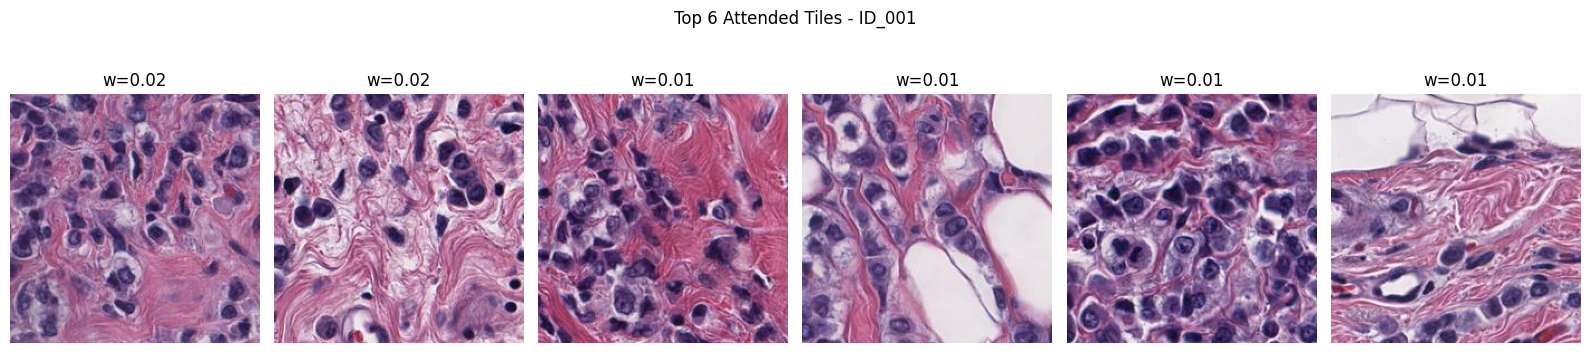

In [21]:
show_top_tiles("ID_001", model, top_k=6)
